# Northwestern County 1st Time Home Buyer Analysis

Author: Armun Shakeri

# Overview

This project analyzes homes available in today's housing market and examines which of those homes would be appropriate for a first time home buyer. Also what factors are most important for a first time home buyer to look at. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to buy their first home,  there are many factors that might raise the price of that home. This project analyzes these factors and explores whether they have a positive or negative affect on price. 

# Data Understanding

The following data is imported from KC housing data and shows different information about homes such as the date a home was sold, price, bedrooms...etc. For this project we will only use some of the data available, others will be removed.

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [3]:
# this shows information regarding variables in kc dataframe 
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Below we drop values that are irrelevant towards first time hombe buyer analysis 
kc = kc.drop(['date', 'sqft_living15', 'sqft_lot15'], axis=1)
kc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045


In [5]:
# Here we drop all Na values. 
kc=kc.dropna()

In [6]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4, and greater than 2 floors will also be removed. 
kc = kc[kc.price<=1000000][kc.bedrooms<=10]
kc.head()

<ipython-input-6-4f7939aed66f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kc = kc[kc.price<=1000000][kc.bedrooms<=10]


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045
6,1321400060,257500.0,3,2.25,1715,6819,2.0,NO,NONE,Average,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327
8,2414600126,229500.0,3,1.00,1780,7470,1.0,NO,NONE,Average,7 Average,1050,730.0,1960,0.0,98146,47.5123,-122.337


In [7]:
# changed year renovated from float64 to int
kc.yr_renovated=kc.yr_renovated.astype(int)

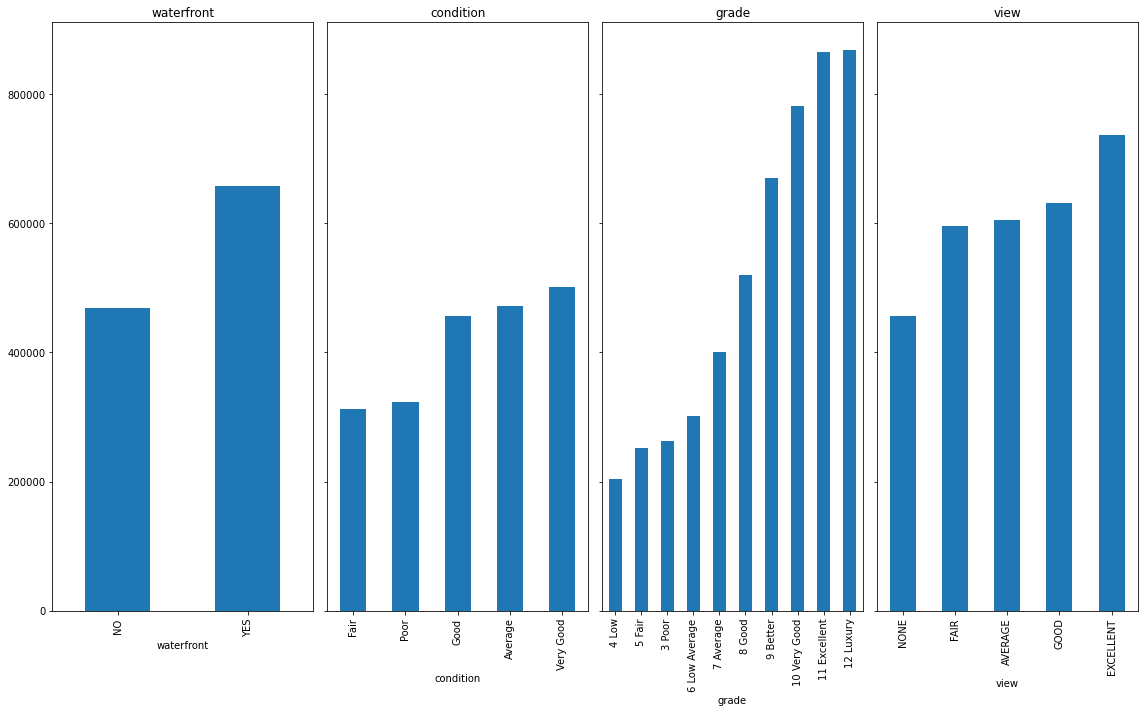

In [8]:
# plotting categorical values vs. price. This shows us all values within categoricals, which values have more
# items and how many categorival values there are. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,10), sharey=True)

categoricals = ['waterfront', 'condition', 'grade', 'view']

for col, ax in zip(categoricals, axes.flatten()):
    (kc.groupby(col)
       .mean()['price']            # take the mean of price for each group
       .sort_values()              # sort the groups in ascending order
       .plot
       .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)              # make the title the name of the column
    
fig.tight_layout()

In [9]:
# create dummy variables for categoricals (waterfront, condition and grade)

dummies = pd.get_dummies(kc[categoricals], prefix=categoricals, drop_first=True)     #create dummies and get rid of multicollinearity

kc = kc.drop(categoricals, axis=1)

kc = pd.concat([kc, dummies], axis=1)

kc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
1,6414100192,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,...,0,0,0,1,0,0,0,0,0,1
3,2487200875,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,...,0,0,0,1,0,0,0,0,0,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,...,0,0,0,0,1,0,0,0,0,1
6,1321400060,257500.0,3,2.25,1715,6819,2.0,1715,?,1995,...,0,0,0,1,0,0,0,0,0,1
8,2414600126,229500.0,3,1.00,1780,7470,1.0,1050,730.0,1960,...,0,0,0,1,0,0,0,0,0,1


In [10]:
kc.sort_values('yr_renovated', ascending=False).head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
4236,6071800100,815000.0,6,3.00,2860,17853,1.0,1430,1430.0,1962,...,0,0,0,0,1,0,0,0,0,1
2293,8712100320,585000.0,5,2.75,2350,4178,1.5,1520,830.0,1922,...,0,0,0,0,1,0,0,0,0,1
16669,5113000420,420000.0,4,2.75,2400,20000,1.0,1170,1230.0,1961,...,0,0,0,0,1,0,0,0,0,1
18560,8935100100,476000.0,4,3.00,2890,6885,1.0,1590,1300.0,1945,...,0,0,0,1,0,0,0,0,0,1
3153,6821100195,830000.0,4,3.00,2020,6000,1.0,1220,800.0,1968,...,0,0,0,0,1,0,0,0,0,1


In [11]:
# Build correlation matrix
corr = kc.corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
id,1.000000,0.017372,0.020663,0.027501,0.015740,-0.136849,0.032385,0.015265,0.028519,-0.014538,...,-0.005275,-0.029922,-0.024250,-0.018581,0.037016,0.011308,0.015948,-0.003954,0.000801,-0.018663
price,0.017372,1.000000,0.297374,0.435886,0.604732,0.092961,0.272821,0.519180,0.058313,0.080385,...,-0.044544,-0.117981,-0.285165,-0.311924,0.165850,0.362899,0.114029,0.074564,0.101597,-0.216589
bedrooms,0.020663,0.297374,1.000000,0.506150,0.608121,0.021248,0.164551,0.479897,0.168446,-0.000818,...,-0.070787,-0.108213,-0.247644,-0.075148,0.113255,0.166715,0.003465,0.013428,0.020755,-0.037095
bathrooms,0.027501,0.435886,0.506150,1.000000,0.708833,0.056071,0.503289,0.629544,0.551585,0.018483,...,-0.054398,-0.144310,-0.383311,-0.266581,0.277159,0.292987,0.018464,0.011894,0.055064,-0.070148
sqft_living,0.015740,0.604732,0.608121,0.708833,1.000000,0.152953,0.339975,0.849580,0.357207,0.012561,...,-0.056201,-0.137445,-0.344185,-0.320253,0.178542,0.391460,0.050722,0.042466,0.092834,-0.148421
sqft_lot,-0.136849,0.092961,0.021248,0.056071,0.152953,1.000000,-0.021943,0.153595,0.040926,0.005354,...,0.001925,0.027643,-0.011671,-0.058623,-0.019002,0.059084,0.013311,-0.010246,0.097362,-0.081716
floors,0.032385,0.272821,0.164551,0.503289,0.339975,-0.021943,1.000000,0.530493,0.511838,-0.011416,...,-0.025263,-0.075971,-0.227224,-0.291241,0.236064,0.260244,-0.003310,-0.033875,-0.005672,0.030435
sqft_above,0.015265,0.519180,0.479897,0.629544,0.849580,0.153595,0.530493,1.000000,0.462647,-0.007162,...,-0.047356,-0.113022,-0.298104,-0.360525,0.150208,0.422822,0.013516,-0.002971,0.041356,-0.049609
yr_built,0.028519,0.058313,0.168446,0.551585,0.357207,0.040926,0.511838,0.462647,1.000000,-0.214284,...,-0.036896,-0.129460,-0.327813,-0.215815,0.234829,0.259988,-0.038578,-0.042602,-0.017382,0.074663
yr_renovated,-0.014538,0.080385,-0.000818,0.018483,0.012561,0.005354,-0.011416,-0.007162,-0.214284,1.000000,...,0.004613,-0.006908,0.013943,0.002262,0.010063,-0.012144,0.036568,0.016444,0.039502,-0.048240


# Data Modeling

In [12]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
count,1.470100e+04,14701.000000,14701.000000,14701.000000,14701.000000,1.470100e+04,14701.000000,14701.000000,14701.000000,14701.000000,...,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000
mean,4.622423e+09,468512.436161,3.326236,2.043943,1958.936807,1.474440e+04,1.472179,1696.449085,1970.866812,71.803619,...,0.001088,0.011360,0.100605,0.443575,0.292701,0.110809,0.006938,0.012992,0.014897,0.928440
std,2.876573e+09,196570.694030,0.880761,0.699848,753.381648,4.078150e+04,0.535293,711.128461,29.069026,371.675534,...,0.032973,0.105979,0.300816,0.496823,0.455018,0.313906,0.083010,0.113245,0.121145,0.257766
min,1.000102e+06,82000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.156500e+09,314000.000000,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,1170.000000,1952.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.955900e+09,435000.000000,3.000000,2.000000,1850.000000,7.500000e+03,1.000000,1510.000000,1975.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.349401e+09,593000.000000,4.000000,2.500000,2420.000000,1.025700e+04,2.000000,2080.000000,1996.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.895000e+09,1000000.000000,10.000000,7.500000,7120.000000,1.651359e+06,3.500000,5710.000000,2015.000000,2015.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


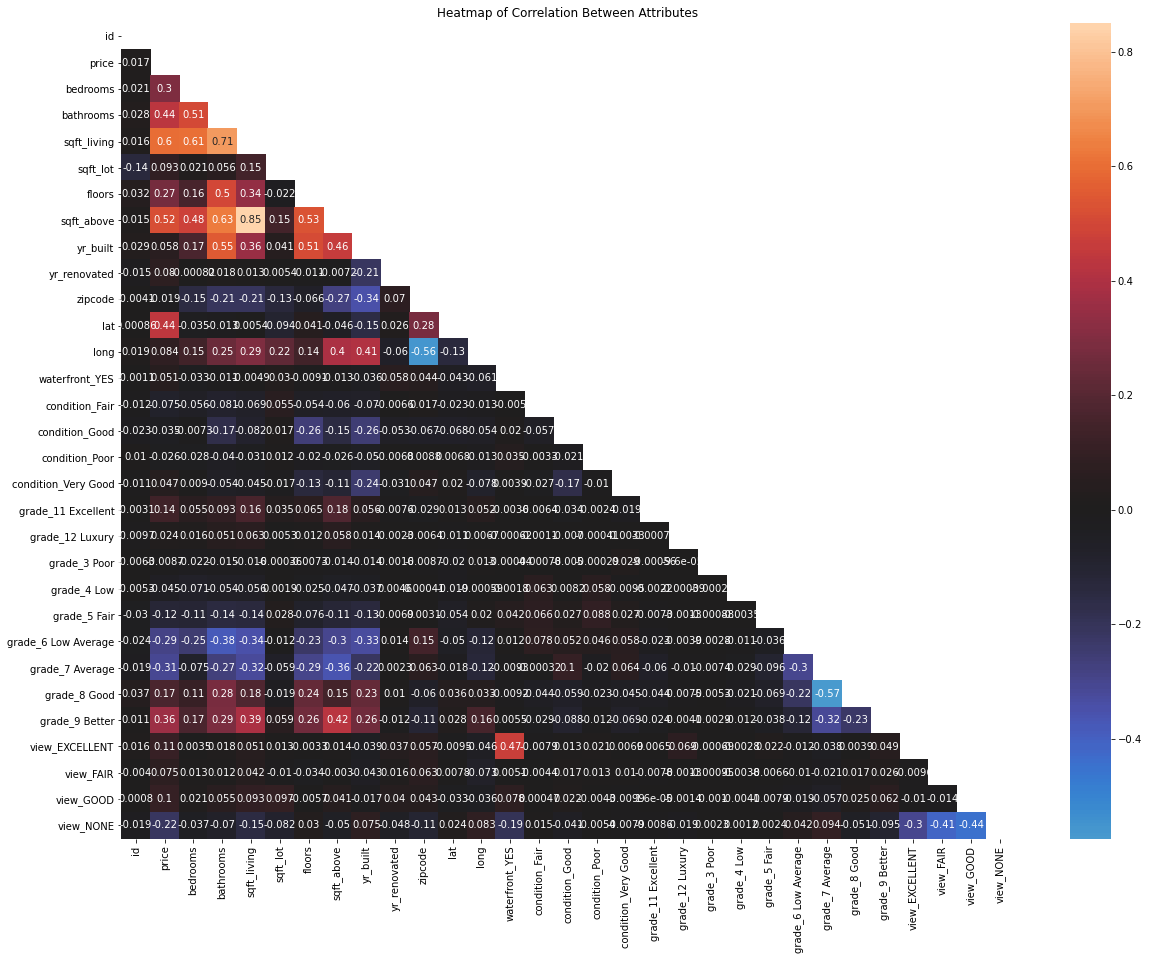

In [13]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(kc.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            center=0);

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# We see below that the highest to lowest correlated are as follows:
# 1) sqft_living x bathrooms
# 2) price x sqft_living
# 3) price x bathrooms

In [65]:
# Build Baseline Model
b = 'price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+sqft_above+yr_built+yr_renovated+zipcode+lat+long+waterfront_YES+condition_Good+condition_Poor+view_EXCELLENT+view_FAIR+view_GOOD+view_NONE'

model = ols(formula=b, data=kc).fit()

In [66]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     1335.
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:38:02   Log-Likelihood:            -1.9292e+05
No. Observations:               14701   AIC:                         3.859e+05
Df Residuals:                   14682   BIC:                         3.860e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -7.132e+05   2.11e+06     -0.337      0.736   -4.86e+06    3.43e+06
bedrooms       -2.019e+04   1481.001    -13.635      0.000   -2.31e+04   -1.73e+04
bathrooms       3.277e+04   2461.036     13.315      0.000    2.79e+04    3.76e+04
sqft_living      119.9477      3.323     36.098      0.000     113.435     126.461
sqft_lot           0.1593      0.026      6.191      0.000       0.109       0.210
floors          3.249e+04   2666.234     12.187      0.000    2.73e+04    3.77e+04
sqft_above        40.5107      3.305     12.258      0.000      34.033      46.988
yr_built       -1300.1158     51.247    -25.370      0.000   -1400.566   -1199.666
yr_renovated       9.7223      2.826      3.441      0.001       4.184      15.261
zipcode         -337.4177     24.086    -14.009      0.000    -384.629    -290.206
lat             6.135e+05   7541.567     81.346      0.000    5.99e+05    6.28e+05
long           -6.045e+04   9329.598     -6.479      0.000   -7.87e+04   -4.22e+04
waterfront_YES  9.054e+04   2.14e+04      4.226      0.000    4.85e+04    1.33e+05
condition_Good  1.467e+04   2424.808      6.051      0.000    9919.260    1.94e+04
condition_Poor -1.041e+05   2.87e+04     -3.632      0.000    -1.6e+05   -4.79e+04
view_EXCELLENT  9.242e+04   1.46e+04      6.339      0.000    6.38e+04    1.21e+05
view_FAIR       1085.0579   1.02e+04      0.106      0.915   -1.89e+04    2.11e+04
view_GOOD       6391.1307   9761.126      0.655      0.513   -1.27e+04    2.55e+04
view_NONE      -8.981e+04   5405.597    -16.615      0.000      -1e+05   -7.92e+04
==============================================================================
Omnibus:                      597.331   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.857
Skew:                           0.397   Prob(JB):                    1.92e-187
Kurtosis:                       3.880   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Visualize terms

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

In [ ]:
# the positive correlation in Y and Fitted vs. X graph shows that sqft_living and price are correlated. 
# this is heteroscedastic 


In [ ]:
# Q-Q Plot

residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

# This Q-Q plot is slightly skewed but mostly normally distributed. 

In [ ]:
# Function to calculate slope
#X = kc['bathrooms']
#y = kc['sqft_living']

#def calc_slope(xs, ys):
    
#    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
#         ((np.mean(xs)**2) - np.mean(xs*xs)))
    
#    return m

#calc_slope(X,y)


In [ ]:
# Function for line of best fit

#def best_fit(xs,ys):
    
#    m = calc_slope(xs,ys)
#    c = np.mean(ys) - m*np.mean(xs)
    
#    return m, c

#m, c = best_fit(X,y)
#m, c

In [ ]:
# Create reg_line function

#def reg_line (m, c, xs):
    
#    return [(m*X)+c for x in xs]

#regression_line = reg_line(m,c,X)

In [ ]:
# Plot points with regression line Bathrooms x Sqft_living

# plt.scatter(X,y,color='#0034',label="Data points")
# plt.plot(X, regression_line, label= "Regression Line")

#plt.xlabel("bathrooms")
#plt.ylabel("sqft_living")

#plt.legend()


In [ ]:
# Plot points with regression line Bedrooms x Sqft_living

#X = kc['bedrooms']

#plt.scatter(X,y,color='#0034',label= "Data points")
#plt.plot(X, regression_line, label= "Regression Line")

#plt.xlabel("bedrooms")
#plt.ylabel("sqft_living")

#plt.legend()